# koan_5 — CNN for MNIST classification

The purpose of this notebook is to build a classic
CNN classifier for the simple MNIST dataset.

## Imports

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Load the MNIST data

In [3]:
# We'll load the data so that it's normalized, meaning that we push
# the mean toward 0, with channel values ending up around [-1, 1] or so.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True,  transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [5]:
# Inspect a single element to see what this data is like.
image, label = train_dataset[0]

In [7]:
image.shape, label

(torch.Size([1, 28, 28]), 5)

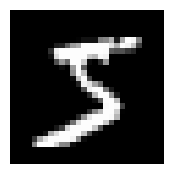

In [13]:
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(image.squeeze(), cmap='gray');